## Newspaper churn
### Data Preprocessing

In [1]:
# The usual suspects
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn
from sklearn.model_selection import train_test_split,RandomizedSearchCV,RepeatedStratifiedKFold,cross_validate

# Assemble pipeline(s)
from sklearn.pipeline import make_pipeline, Pipeline
from imblearn.pipeline import Pipeline as imbPipeline
from imblearn.under_sampling import EditedNearestNeighbours
from sklearn.compose import make_column_selector

# Features engineering
from feature_engine.selection import DropFeatures,DropConstantFeatures,DropDuplicateFeatures,DropCorrelatedFeatures
from feature_engine.outliers import OutlierTrimmer
from feature_engine.imputation import RandomSampleImputer

# Sampling
from imblearn.over_sampling import SMOTENC

In [2]:
# Dsplay pipelines
from sklearn import set_config
set_config(display="diagram")

In [3]:
import warnings
warnings.filterwarnings('ignore')

## Data Loading

In [4]:
# The majority of the features is categorial.
df = pd.read_excel('../../../data/newspaper-churn.xlsx')
df.sample(10)

,SubscriptionID,HH Income,Home Ownership,Ethnicity,dummy for Children,Year Of Residence,Age range,Language,Address,State,City,County,Zip Code,weekly fee,Deliveryperiod,Nielsen Prizm,reward program,Source Channel,Subscriber
6254,180539245,"$ 80,000 - $89,999",OWNER,Arab,N,7,70-74,Arabic,2130 E ALTURA AVE,CA,ORANGE,ORANGE,92867,$0 - $0.01,SunOnly,MM,0,Partner,NO
13233,160246580,"$250,000 - $299,999",OWNER,Arab,Y,15,45-49,English,640 ALSACE DR,CA,CORONA,RIVERSIDE,92882,$0 - $0.01,SunOnly,FM,0,Partner,NO
12424,181543619,"$ 70,000 - $79,999",OWNER,Japanese,Y,22,45-49,English,5558 LEMON AVE,CA,LONG BEACH,LOS ANGELES,90805,$3.00 - $3.99,THU-SUN,FM,0,Kiosk1,NO
4530,181268392,"$ 40,000 - $49,999",RENTER,Hispanic,N,12,45-49,Spanish,17402 KOLEDO LN APT B,CA,HUNTINGTON BEACH,ORANGE,92647,$0 - $0.01,7Day,FE,0,Partner,NO
10997,130589227,"$150,000 - $174,999",OWNER,German,N,14,60-64,English,4062 GRANDVIEW DR,CA,BREA,ORANGE,92823,$4.00 - $4.99,7Day,YW,0,TeleIn,NO
6101,130171166,"$125,000 - $149,999",OWNER,English,N,45,NaN,English,2108 ROSEMONT ST,CA,PLACENTIA,ORANGE,92870,$2.00 - $2.99,SunOnly,FM,0,CustCall,NO
2582,170104390,"$125,000 - $149,999",OWNER,English,Y,35,65-69,English,1358 JASMINE CIR,CA,CORONA,RIVERSIDE,92880,$2.00 - $2.99,7Day,FM,0,DirectMl,NO
1273,110184366,"$ 30,000 - $39,999",OWNER,English,N,2,35-39,English,11722 DEBBIE LN,CA,GARDEN GROVE,ORANGE,92840,$1.00 - $1.99,7Day,FM,0,TeleIn,NO
10628,180477778,"Under $20,000",RENTER,Portuguese,N,2,24 years or less,Portuguese,3701 E CHAPMAN AVE APT 42,CA,ORANGE,ORANGE,92869,$1.00 - $1.99,7DayT,YM,0,TeleIn,NO
15719,120601210,"$ 70,000 - $79,999",OWNER,Korean,N,3,35-39,English,9710 WALKER CT,CA,CYPRESS,ORANGE,90630,$6.00 - $6.99,7Day,MM,0,CustCall,NO


## Handling Datatypes

In [5]:
df.dtypes

SubscriptionID         int64
HH Income             object
Home Ownership        object
Ethnicity             object
dummy for Children    object
Year Of Residence      int64
Age range             object
Language              object
Address               object
State                 object
City                  object
County                object
Zip Code               int64
weekly fee            object
Deliveryperiod        object
Nielsen Prizm         object
reward program         int64
Source Channel        object
Subscriber            object
dtype: object

In [6]:
# Convert the target variable to categorical order form.
df.rename(columns={'Subscriber':'target'}, inplace=True)
df['target'].replace({'NO':0, 'YES':1}, inplace=True)
target_type = pd.CategoricalDtype(categories=sorted(df.target.unique()), ordered=True)
df["target"] = df["target"].astype(target_type)
# Convert categorical features to categorical datatype.
df[df.select_dtypes(['object']).columns] = df.select_dtypes(['object']).apply(lambda x: x.astype('category'))

In [7]:
df.dtypes

SubscriptionID           int64
HH Income             category
Home Ownership        category
Ethnicity             category
dummy for Children    category
Year Of Residence        int64
Age range             category
Language              category
Address               category
State                 category
City                  category
County                category
Zip Code                 int64
weekly fee            category
Deliveryperiod        category
Nielsen Prizm         category
reward program           int64
Source Channel        category
target                category
dtype: object

## Outliers Removal

<function matplotlib.pyplot.show(close=None, block=None)>

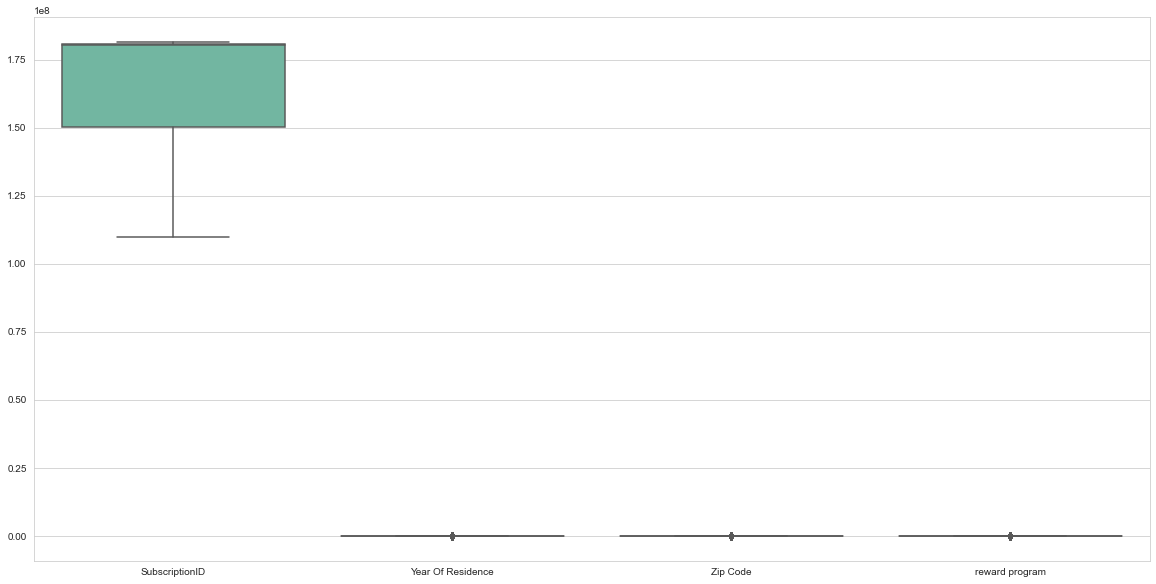

In [8]:
# Check Outliers
plt.figure(figsize=(20, 10))
sns.boxplot(data=df, orient="v", palette="Set2")
plt.show

In [11]:
# Remove outliers
ot = OutlierTrimmer(capping_method='gaussian', tail='both', fold=3, missing_values='ignore')
ot.fit(df)

OutlierTrimmer(missing_values='ignore', tail='both')

In [12]:
print("Minimum caps :", ot.left_tail_caps_)
print("Maximum caps :", ot.right_tail_caps_)

Minimum caps : {'SubscriptionID': 93672503.32140023, 'Year Of Residence': -21.763854062821792, 'Zip Code': 90223.66603856116, 'reward program': -27.564428411589894}
Maximum caps : {'SubscriptionID': 235073331.28068113, 'Year Of Residence': 48.85612779350612, 'Zip Code': 94625.41778357695, 'reward program': 29.76575291490115}


In [13]:
df_out = ot.transform(df)

In [14]:
print("train data shape after removing outliers:", df_out.shape)
print(f"{df.shape[0] - df_out.shape[0]} observations are removed\n")

train data shape after removing outliers: (15554, 19)
301 observations are removed



<function matplotlib.pyplot.show(close=None, block=None)>

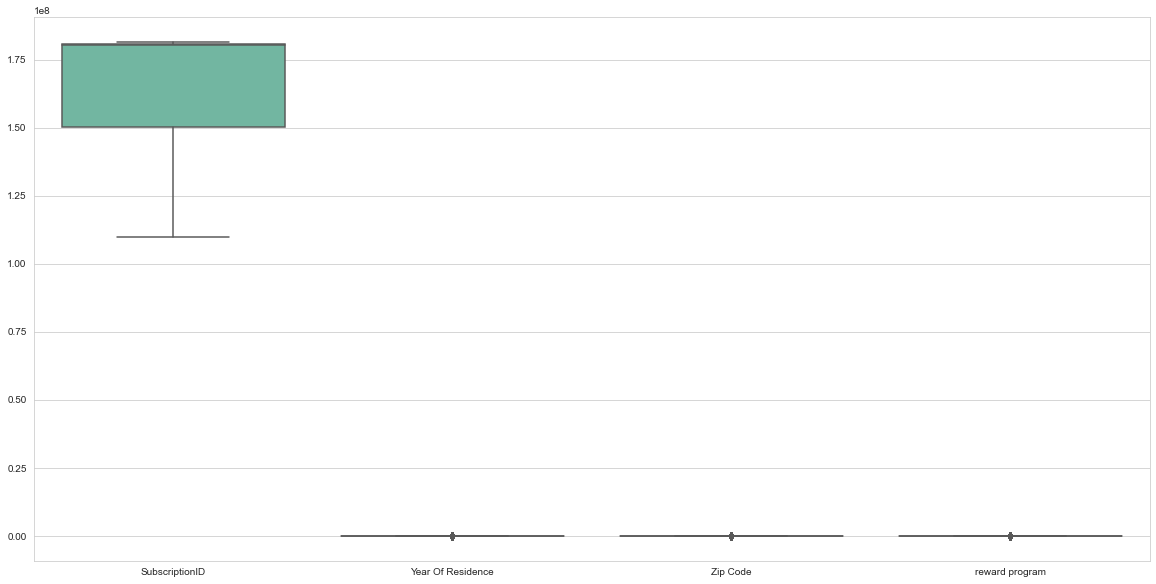

In [15]:
# Check Outliers
plt.figure(figsize=(20, 10))
sns.boxplot(data=df_out, orient="v", palette="Set2")
plt.show

## Feature Engineering

In [16]:
X = df_out.drop('target', axis=1)
y = df_out['target']
X.shape

(15554, 18)

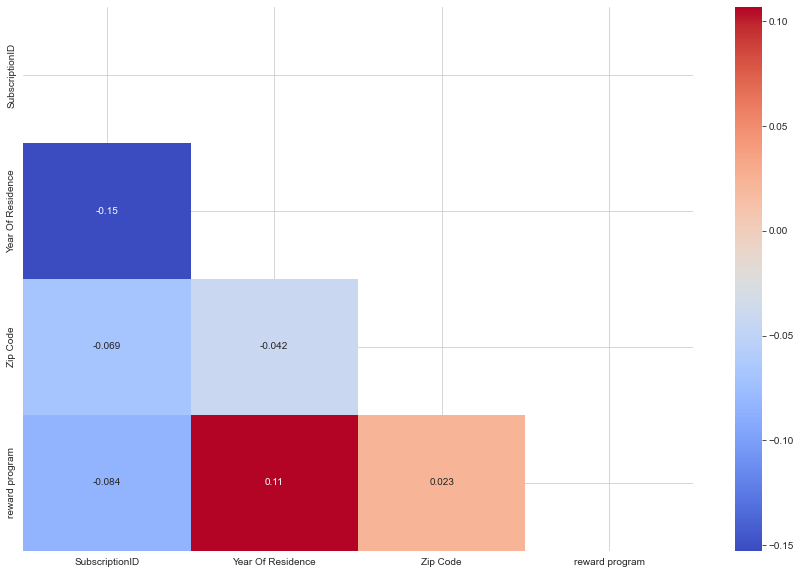

In [17]:
# Show features correlations
plt.figure(figsize=(15, 10))
sns.heatmap(data=X.corr(), cmap='coolwarm', mask=np.triu(X.corr()), annot=True)
plt.show()

In [18]:
from feature_engine.imputation import MeanMedianImputer, CategoricalImputer

ppl_fe = Pipeline([
    # Step 1: Features engineering
    ('drop_irrelevant', DropFeatures(['SubscriptionID','Address'])),
    ('drop_constant', DropConstantFeatures(tol=1, missing_values='ignore')),
    ('drop_duplicates', DropDuplicateFeatures()),
    ('drop_correlated', DropCorrelatedFeatures(method='pearson', threshold=0.8))
])

In [19]:
display(ppl_fe)

Pipeline(steps=[('drop_irrelevant',
                 DropFeatures(features_to_drop=['SubscriptionID', 'Address'])),
                ('drop_constant',
                 DropConstantFeatures(missing_values='ignore')),
                ('drop_duplicates', DropDuplicateFeatures()),
                ('drop_correlated', DropCorrelatedFeatures())])

In [20]:
cols_before = X.columns
X_fe = ppl_fe.fit_transform(X)
X_fe.shape

(15554, 15)

In [21]:
# show dropped Correlated features
cols_after = X_fe.columns
train_not_test = cols_before.difference(cols_after)
print(f'Dropped features: {list(train_not_test)}')

Dropped features: ['Address', 'State', 'SubscriptionID']


## Handling Missing Data

In [17]:
# Selecting categorical and numeric features
sel_numeric = make_column_selector(dtype_include=['number'])
col_numerical = sel_numeric(X_fe)

sel_categorical = make_column_selector(dtype_include=['object','category'])
col_categorical = sel_categorical(X_fe)

In [18]:
ppl_imp = Pipeline([
    # Step 1: Impute and scale features
    ('num', MeanMedianImputer(imputation_method='median', variables=col_numerical)),
    ('cat', RandomSampleImputer(variables=col_categorical))
])

In [19]:
display(ppl_imp)

Pipeline(steps=[('num',
                 MeanMedianImputer(variables=['Year Of Residence', 'Zip Code',
                                              'reward program'])),
                ('cat',
                 RandomSampleImputer(variables=['HH Income', 'Home Ownership',
                                                'Ethnicity',
                                                'dummy for Children',
                                                'Age range', 'Language', 'City',
                                                'County', 'weekly fee',
                                                'Deliveryperiod',
                                                'Nielsen Prizm',
                                                'Source Channel']))])

In [20]:
X_im = ppl_imp.fit_transform(X_fe)
X_im

,HH Income,Home Ownership,Ethnicity,dummy for Children,Year Of Residence,Age range,Language,City,County,Zip Code,weekly fee,Deliveryperiod,Nielsen Prizm,reward program,Source Channel
0,"$ 30,000 - $39,999",RENTER,German,N,1,25-29,German,LONG BEACH,LOS ANGELES,90802,$7.00 - $7.99,7Day,FM,0,CircAdm
1,"$500,000 Plus",OWNER,unknown,Y,14,50-54,English,NEWPORT COAST,ORANGE,92657,$0.01 - $0.50,SunOnly,MW,0,Partner
2,"$100,000 - $124,999",OWNER,Italian,Y,7,45-49,English,IRVINE,ORANGE,92604,$0.01 - $0.50,SunOnly,MW,0,Partner
3,"$200,000 - $249,999",OWNER,English,N,23,55-59,English,LAGUNA NIGUEL,ORANGE,92677,$1.00 - $1.99,SunOnly,MW,1,Internet
4,"$ 50,000 - $59,999",OWNER,Italian,N,23,60-64,English,RANCHO SANTA MARGARITA,ORANGE,92688,$8.00 - $8.99,Thu-Sun,MM,0,Crew
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15850,"$ 80,000 - $89,999",OWNER,Italian,N,3,25-29,English,FOUNTAIN VALLEY,ORANGE,92708,$0.01 - $0.50,SunOnly,MW,0,Partner
15851,"$ 80,000 - $89,999",OWNER,Italian,N,3,25-29,English,FOUNTAIN VALLEY,ORANGE,92708,$0 - $0.01,SunOnly,MW,0,Partner
15852,"$150,000 - $174,999",OWNER,Irish,Y,12,60-64,English,CYPRESS,ORANGE,90630,$1.00 - $1.99,7Day,MW,0,DirectMl
15853,"$ 80,000 - $89,999",OWNER,Hispanic,Y,30,25-29,English,CORONA,RIVERSIDE,92882,$0 - $0.01,SunOnly,FE,0,Partner


In [21]:
X_im.dtypes

HH Income             category
Home Ownership        category
Ethnicity             category
dummy for Children    category
Year Of Residence        int64
Age range             category
Language              category
City                  category
County                category
Zip Code                 int64
weekly fee            category
Deliveryperiod        category
Nielsen Prizm         category
reward program           int64
Source Channel        category
dtype: object

## Balancing Data

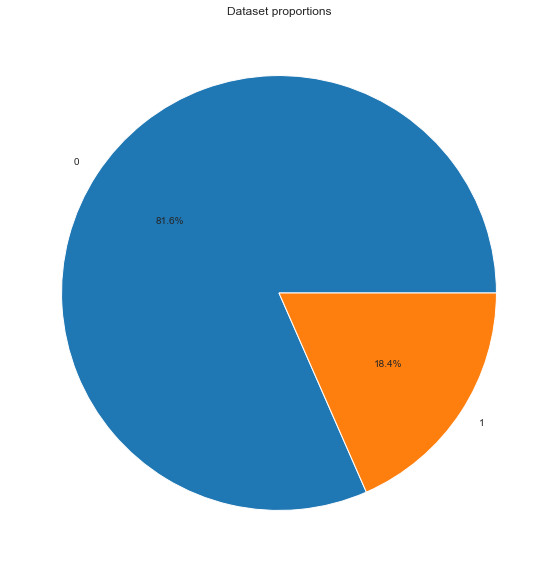

In [22]:
labels, counts = np.unique(y, return_counts=True)

plt.figure(figsize=(10, 10))
plt.pie(counts, autopct='%1.1f%%', labels=labels)
plt.title('Dataset proportions')
plt.show()

In [23]:
cat_cols = []
for col in X_im.columns:
    if X_im[col].dtype == 'category':
        cat_cols.append(True)
    else:
        cat_cols.append(False)

In [26]:
# Sampling Pipeline
ppl_sample = imbPipeline([
    ('over-sampling', SMOTENC(categorical_features=cat_cols)),
    #('under-sampling', EditedNearestNeighbours())
])

In [27]:
X_sm, y_sm = ppl_sample.fit_resample(X_im,y)

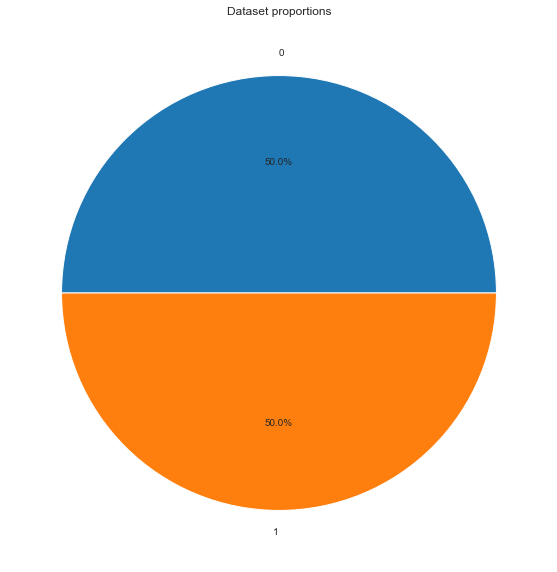

In [28]:
labels, counts = np.unique(y_sm, return_counts=True)

plt.figure(figsize=(10, 10))
plt.pie(counts, autopct='%1.1f%%', labels=labels)
plt.title('Dataset proportions')
plt.show()

### Save cleaned data

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.2)
df_train_clean = pd.concat([X_train, y_train], axis=1)
df_test_clean = pd.concat([X_test, y_test], axis=1)
df_train_clean.to_csv('../../../data/newspaper-churn-train.csv', index=False)
df_test_clean.to_csv('../../../data/newspaper-churn-test.csv', index=False)